In [17]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid

sns.set(rc={'figure.figsize':(8,6)})
sns.set_context("paper", font_scale=2) 
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings("ignore")

# Проклятье размерности

Пусть есть выборка из многомерного равномерного распределения на гиперкубе $[0, 1]^d$
Рассмотрим объект $u$ в начале координат и будем считать окрестностью объекта $u$ "подкуб" со стороной $\epsilon$: $[0, \epsilon]^d$.

__Задача 1:__ 

C какой вероятностью объект выборки окажется в окрестности $u$? 

In [5]:
eps = 0.99

def generate_points(d):
    return np.random.uniform(size=([5000, d]))

In [3]:
np.mean(generate_points(d=1).max(-1) < eps)

0.991

In [4]:
np.mean(generate_points(d=3).max(-1) < eps)

0.9732

Посчитаем для произвольного d вероятность $p(x \in [0, \epsilon]^d)$ попасть в гиперкуб со стороной $\epsilon$

In [99]:
ds = []
probs = []
for d in range(1, 500):
    data = generate_points(d)
    ds.append(d)
    probs.append(np.mean(data.max(-1) < eps))
ds = np.array(ds)

Text(0, 0.5, 'Вероятность найти соседа')

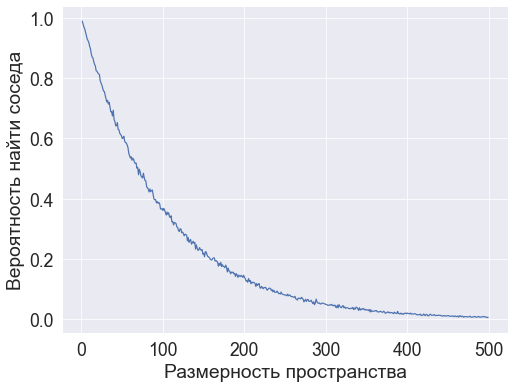

In [100]:
plt.plot(ds, probs)
plt.xlabel("Размерность пространства")
plt.ylabel("Вероятность найти соседа")

## Генерация набора данных 

In [11]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 


X, Y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_classes=3, 
                           n_redundant=0,
                           scale=1.5,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=250, 
                                                    random_state=0)

## Метод ближайшего соседа

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=1)

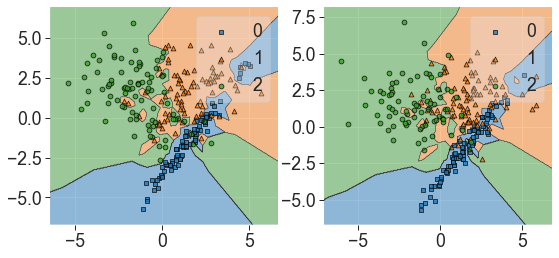

In [14]:
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))


plot_decision_regions(X_train, Y_train, model, ax=ax[0])
plot_decision_regions(X_test, Y_test, model, ax=ax[1])

plt.show()

In [15]:
from sklearn.metrics import classification_report

In [16]:
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        84
           1       0.73      0.78      0.75        88
           2       0.83      0.76      0.79        78

    accuracy                           0.81       250
   macro avg       0.81      0.81      0.81       250
weighted avg       0.81      0.81      0.81       250



## Метод k-ближайших соседей

______________________________
k=2
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        84
           1       0.70      0.84      0.77        88
           2       0.94      0.64      0.76        78

    accuracy                           0.81       250
   macro avg       0.84      0.81      0.81       250
weighted avg       0.83      0.81      0.81       250

______________________________
k=5
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        84
           1       0.76      0.74      0.75        88
           2       0.84      0.78      0.81        78

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250

______________________________
k=20
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        84
           1       0.74

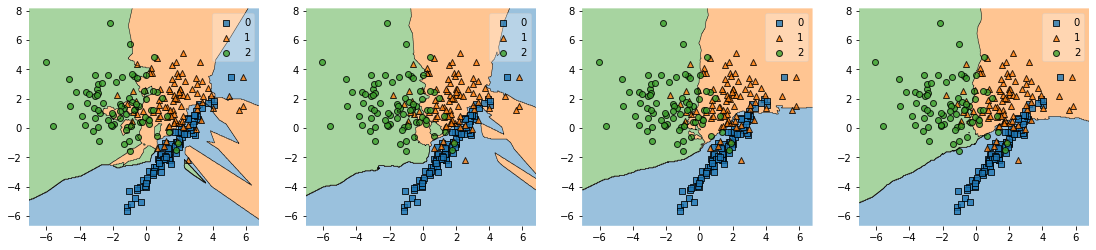

In [11]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

for i, n_neighbors in enumerate([2, 5, 20, 50]):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, Y_train)
    ax = fig.add_subplot(gs[i])
    plot_decision_regions(X_test, Y_test, model, ax=ax)
    
    print('_'*30)
    print(f'k={n_neighbors}')
    print(classification_report(Y_test, model.predict(X_test)))
    
plt.show()

In [12]:
from tqdm import tqdm_notebook

In [13]:
accuracy = []
for n_neighbors in tqdm_notebook(range(1, 50, 3)):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, Y_train)
    accuracy.append( np.mean(model.predict(X_test) == Y_test)) 

  0%|          | 0/17 [00:00<?, ?it/s]

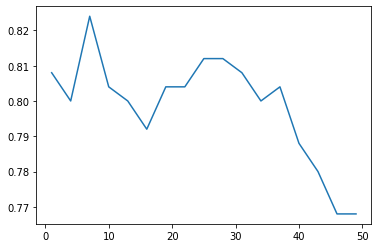

In [14]:
plt.plot(range(1, 50, 3), accuracy)

## Метод k-ближайших соседей с линейно убывающими весами

In [15]:
def linear_weights(distance):
    k = distance.shape[1]
    return ((k - np.arange(0, k))/k) * np.ones_like(distance)

______________________________
k=2
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        84
           1       0.73      0.78      0.75        88
           2       0.83      0.76      0.79        78

    accuracy                           0.81       250
   macro avg       0.81      0.81      0.81       250
weighted avg       0.81      0.81      0.81       250

______________________________
k=5
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        84
           1       0.75      0.75      0.75        88
           2       0.83      0.77      0.80        78

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.81       250

______________________________
k=20
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        84
           1       0.74

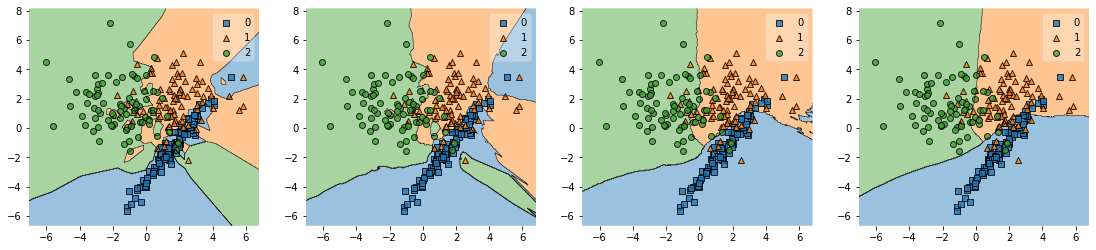

In [16]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

for i, n_neighbors in enumerate([2, 5, 20, 50]):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=linear_weights)
    model.fit(X_train, Y_train)
    ax = fig.add_subplot(gs[i])
    plot_decision_regions(X_test, Y_test, model, ax=ax)
    
    print('_'*30)
    print(f'k={n_neighbors}')
    print(classification_report(Y_test, model.predict(X_test)))
    
plt.show()

  0%|          | 0/17 [00:00<?, ?it/s]

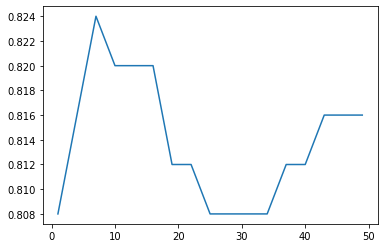

In [17]:
accuracy = []
for n_neighbors in tqdm_notebook(range(1, 50, 3)):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=linear_weights)
    model.fit(X_train, Y_train)
    accuracy.append( np.mean(model.predict(X_test) == Y_test)) 
plt.plot(range(1, 50, 3), accuracy)

## Окно Парзена

In [18]:
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

______________________________
k=0.5
              precision    recall  f1-score   support

           0       0.74      0.93      0.83        84
           1       0.74      0.70      0.72        88
           2       0.85      0.67      0.75        78

    accuracy                           0.77       250
   macro avg       0.78      0.77      0.76       250
weighted avg       0.78      0.77      0.76       250

______________________________
k=1
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        84
           1       0.76      0.72      0.74        88
           2       0.83      0.74      0.78        78

    accuracy                           0.80       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.80      0.80      0.80       250

______________________________
k=3
              precision    recall  f1-score   support

           0       0.81      0.82      0.82        84
           1       0.7

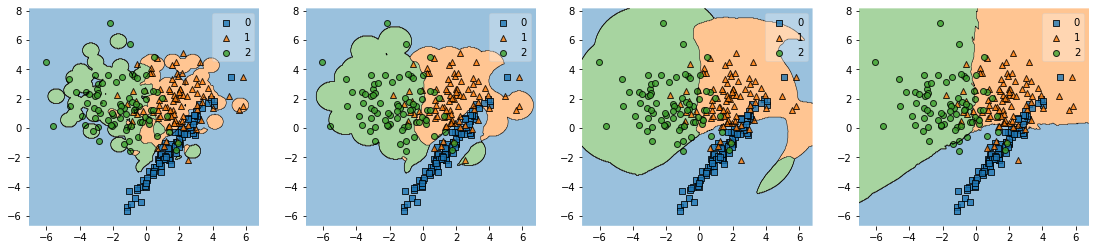

In [19]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

for i, h in enumerate([0.5, 1, 3, 10]):
    model = KNeighborsClassifier(n_neighbors=100, weights=lambda x: K(x, h=h))
    model.fit(X_train, Y_train)
    ax = fig.add_subplot(gs[i])
    plot_decision_regions(X_test, Y_test, model, ax=ax)
    
    print('_'*30)
    print(f'k={h}')
    print(classification_report(Y_test, model.predict(X_test)))
    
plt.show()

### Генерация признаков на основе метода ближайших соседей

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from multiprocessing import Pool

In [23]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 


X, Y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_classes=2, 
                           n_redundant=0,
                           scale=1.5,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(pd.DataFrame(X), pd.Series(Y), 
                                                    test_size=250, 
                                                    random_state=0)

In [24]:
X_train

,0,1
476,3.065734,0.801304
162,1.942566,1.731770
34,1.911625,-1.015051
44,2.903835,2.112898
97,2.200040,1.028056
...,...,...
323,-0.868332,0.027329
192,2.792398,0.297465
117,2.965842,0.726898
47,4.664187,3.177209


In [25]:
class NearestNeighborsFeats(BaseEstimator, ClassifierMixin):
    ''' 
        Этот класс реализует создание KNN признаков.
    '''

    def __init__(self, k_list, metric, n_jobs = 4,  n_classes=None, n_neighbors=None, eps=1e-10):
        self.n_jobs = n_jobs
        self.k_list = k_list
        self.metric = metric
        self.n_neighbors = n_neighbors or max(k_list)
        self.eps = eps
        self.n_classes_ = n_classes

    def fit(self, X, y):
        # Создание объекта-классификатора  
        self.NN = NearestNeighbors(n_neighbors=max(self.k_list),
                                   metric=self.metric,
                                   n_jobs=-1,
                                   algorithm='brute' if self.metric == 'cosine' else 'auto')
        self.NN.fit(X)

        # Сохраниение меток 
        self.y_train = y.values

        # Определение количества классов 
        self.n_classes = len(np.unique(y)) if self.n_classes_ is None else self.n_classes_

    def predict(self, X):
        '''
            Создание признаков для каждого объекта в наборе данных
        '''
        result = []
        for k in self.k_list:
            
            neighs_dist, neighs = self.NN.kneighbors(X)
            neighs_dist, neighs = neighs_dist[:, :k], neighs[:, :k] 

            neighs_y = self.y_train[neighs]

            # 1. Доля объектов каждого класса среди ближайших соседей
            fraction = np.mean(neighs_y, axis = 1)

            # 2. Минимальная дистанция до объектов каждого из классов

            # где y=1  не трогаем значение дистанции, где y=0 прибалвяем к дистанции np.inf
            ones = np.min(neighs_dist + np.where(neighs_y, 0, np.inf), axis =1)
            zeros = np.min(neighs_dist + np.where(neighs_y, np.inf, 0), axis =1)

            # 3. Средняя дистанция 

            mean_distance = np.median(neighs_dist, axis=1)

            # 4. Минимальная дистанция до объектов каждого класса деленная на расстояние до среднего объекта

            norm_ones = ones/(mean_distance + self.eps)

            norm_zeros = zeros/(mean_distance + self.eps)

            # 6. Средняя дистанция до объекта каждого класса из k ближайших соседей

            ones_mean = (np.sum(neighs_dist*neighs_y, axis=1) + self.eps) / np.sum(neighs_y, axis=1)

            mask = 1 * ~neighs_y.astype(bool)

            zeros_mean = (np.sum(neighs_dist*mask, axis=1) + self.eps) / np.sum(mask, axis=1)
            
            column_names = ['fraction_ones', 'min_distance_one', 'min_distance_zero',
                            'mean_distance', 'norm_min_distance_one', 'norm_min_distance_zero',
                            'mean_distance_one', 'min_distance_zero']
            
            result.append(pd.DataFrame(data = np.c_[[fraction, ones, zeros, mean_distance,
                                                      norm_ones, norm_zeros, ones_mean, zeros_mean]].T, 
                                        columns = column_names, 
                                        index = X.index).add_suffix(f'_{k}'))

        return pd.concat(result, axis=1)

In [26]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, 
                                                     test_size=125, 
                                                     random_state=0)

In [29]:
nnf = NearestNeighborsFeats(k_list=[3,5,6], metric='euclidean')

In [30]:
nnf.fit(X_valid, Y_valid)

In [31]:
train_features = nnf.predict(X_train)
test_features = nnf.predict(X_test)

In [33]:
X_train

,0,1
279,0.148363,-2.935865
197,-1.152930,-5.679582
149,4.132177,2.279150
169,1.397934,-1.952200
183,2.518048,0.663807
...,...,...
352,2.657000,0.342862
163,2.262287,-0.437930
377,-1.893868,0.329073
274,2.588398,0.448696


In [32]:
train_features

,fraction_ones_3,min_distance_one_3,min_distance_zero_3,mean_distance_3,norm_min_distance_one_3,norm_min_distance_zero_3,mean_distance_one_3,min_distance_zero_3,fraction_ones_5,min_distance_one_5,...,mean_distance_one_5,min_distance_zero_5,fraction_ones_6,min_distance_one_6,min_distance_zero_6,mean_distance_6,norm_min_distance_one_6,norm_min_distance_zero_6,mean_distance_one_6,min_distance_zero_6
279,0.000000,inf,0.088773,0.129613,inf,0.684907,inf,0.125221,0.0,inf,...,inf,0.188340,0.000000,inf,0.088773,0.219119,inf,0.405134,inf,0.217245
197,0.000000,inf,0.540580,0.690006,inf,0.783442,inf,0.790916,0.0,inf,...,inf,1.101967,0.000000,inf,0.540580,1.350900,inf,0.400163,inf,1.184332
149,0.333333,0.575004,0.226308,0.421414,1.364462,0.537020,0.575004,0.323861,0.2,0.575004,...,0.575004,0.508488,0.333333,0.575004,0.226308,0.629024,0.914121,0.359777,0.713864,0.508488
169,0.000000,inf,0.107813,0.177438,inf,0.607606,inf,0.180461,0.0,inf,...,inf,0.215104,0.000000,inf,0.107813,0.257826,inf,0.418161,inf,0.242659
183,0.333333,0.483535,0.396853,0.472454,1.023453,0.839981,0.483535,0.434654,0.2,0.483535,...,0.483535,0.471615,0.166667,0.483535,0.396853,0.485312,0.996338,0.817727,0.483535,0.492522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.000000,inf,0.197160,0.227046,inf,0.868371,inf,0.222109,0.0,inf,...,inf,0.277955,0.000000,inf,0.197160,0.290697,inf,0.678234,inf,0.316006
163,0.333333,0.212170,0.090042,0.209447,1.013000,0.429902,0.212170,0.149744,0.4,0.212170,...,0.217199,0.208978,0.333333,0.212170,0.090042,0.217199,0.976846,0.414559,0.217199,0.252245
377,1.000000,0.127783,inf,1.069005,0.119535,inf,0.767664,inf,1.0,0.127783,...,0.965887,inf,1.000000,0.127783,inf,1.145457,0.111557,inf,1.048393,inf
274,0.000000,inf,0.297840,0.350383,inf,0.850041,inf,0.335367,0.0,inf,...,inf,0.382641,0.000000,inf,0.297840,0.385763,inf,0.772079,inf,0.401475


In [82]:
train_features.replace({np.inf: 0}, inplace=True)
test_features.replace({np.inf: 0}, inplace=True)

In [83]:
lr = LogisticRegression()

In [84]:
lr.fit(train_features, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
print(classification_report(Y_test, lr.predict(test_features)))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89       119
           1       0.96      0.83      0.89       131

    accuracy                           0.89       250
   macro avg       0.90      0.90      0.89       250
weighted avg       0.90      0.89      0.89       250



####  EM-алгоритм

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
plt.style.use('seaborn')

In [112]:
# Первый кластер данных
num1, mu1, var1 = 400, [0.5, 0.5], [1, 3]
X1 = np.random.multivariate_normal(mu1, np.diag(var1), num1)

# Второй кластер данных
num2, mu2, var2 = 600, [5.5, 2.5], [2, 2]
X2 = np.random.multivariate_normal(mu2, np.diag(var2), num2)

# Третий кластер данных
num3, mu3, var3 = 1000, [1, 7], [6, 2]
X3 = np.random.multivariate_normal(mu3, np.diag(var3), num3)

# слить вместе
X = np.vstack((X1, X2, X3))

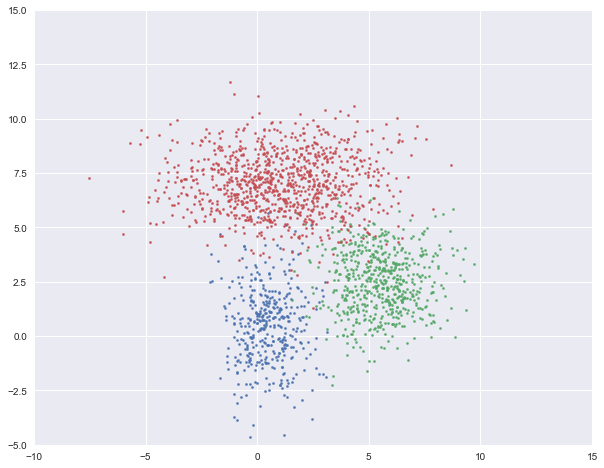

In [113]:
plt.figure(figsize=(10, 8))
plt.axis([-10, 15, -5, 15])
plt.scatter(X1[:, 0], X1[:, 1], s=5)
plt.scatter(X2[:, 0], X2[:, 1], s=5)
plt.scatter(X3[:, 0], X3[:, 1], s=5)
plt.show()

In [124]:
n_clusters = 3
n_points = len(X)
Mu = [[0, -1], [6, 0], [0, 9]]
Var = [[1, 1], [1, 1], [1, 1]]
Pi = [1 / n_clusters] * 3

In [125]:
W = np.ones((n_points, n_clusters)) / n_clusters 
Pi = W.sum(axis=0) / W.sum()

In [126]:
def update_W(X, Mu, Var, Pi):
    n_points, n_clusters = len(X), len(Pi)
    pdfs = np.zeros(((n_points, n_clusters)))
    for i in range(n_clusters):
        pdfs[:, i] = Pi[i] * multivariate_normal.pdf(X, Mu[i], np.diag(Var[i]))
    W = pdfs / pdfs.sum(axis=1).reshape(-1, 1)
    return W


def update_Pi(W):
    Pi = W.sum(axis=0) / W.sum()
    return Pi

In [127]:
def logLH(X, Pi, Mu, Var):
    n_points, n_clusters = len(X), len(Pi)
    pdfs = np.zeros(((n_points, n_clusters)))
    for i in range(n_clusters):
        pdfs[:, i] = Pi[i] * multivariate_normal.pdf(X, Mu[i], np.diag(Var[i]))
    return np.mean(np.log(pdfs.sum(axis=1)))

In [128]:
def plot_clusters(X, Mu, Var, Mu_true=None, Var_true=None):
    colors = ['b', 'g', 'r']
    n_clusters = len(Mu)
    plt.figure(figsize=(10, 8))
    plt.axis([-10, 15, -5, 15])
    plt.scatter(X[:, 0], X[:, 1], s=5)
    ax = plt.gca()
    for i in range(n_clusters):
        plot_args = {'fc': 'None', 'lw': 2, 'edgecolor': colors[i], 'ls': ':'}
        ellipse = Ellipse(Mu[i], 3 * Var[i][0], 3 * Var[i][1], **plot_args)
        ax.add_patch(ellipse)
    if (Mu_true is not None) & (Var_true is not None):
        for i in range(n_clusters):
            plot_args = {'fc': 'None', 'lw': 2, 'edgecolor': colors[i], 'alpha': 0.5}
            ellipse = Ellipse(Mu_true[i], 3 * Var_true[i][0], 3 * Var_true[i][1], **plot_args)
            ax.add_patch(ellipse)         
    plt.show()

In [129]:
def update_Mu(X, W):
    n_clusters = W.shape[1]
    Mu = np.zeros((n_clusters, 2))
    for i in range(n_clusters):
        Mu[i] = np.average(X, axis=0, weights=W[:, i])
    return Mu

def update_Var(X, Mu, W):
    n_clusters = W.shape[1]
    Var = np.zeros((n_clusters, 2))
    for i in range(n_clusters):
        Var[i] = np.average((X - Mu[i]) ** 2, axis=0, weights=W[:, i])
    return Var

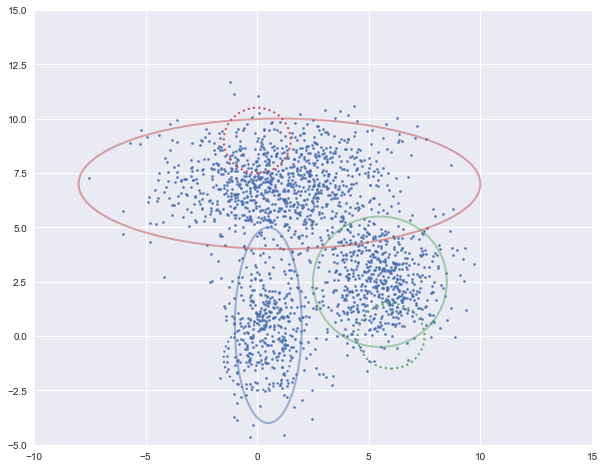

log-likehood:-8.123


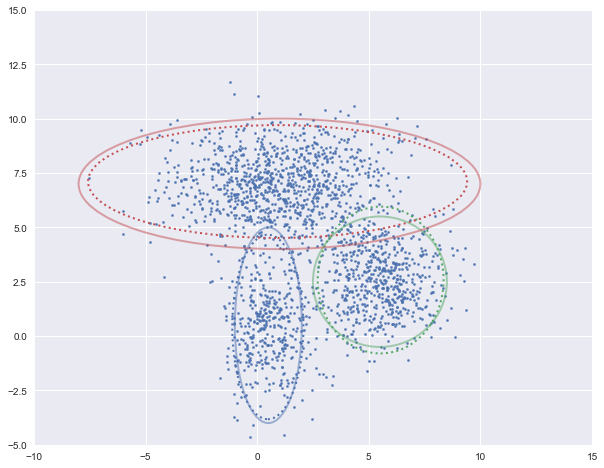

log-likehood:-4.717


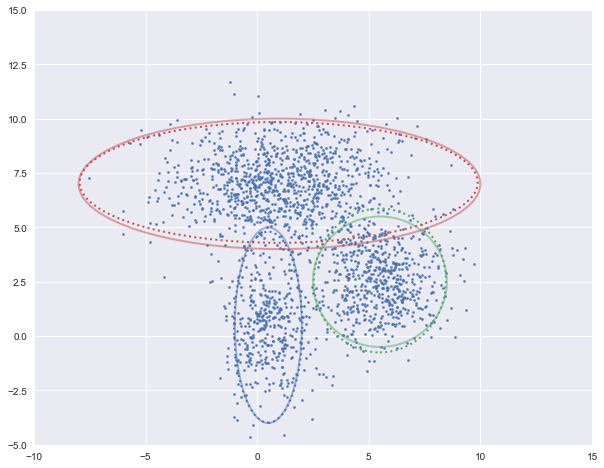

log-likehood:-4.715


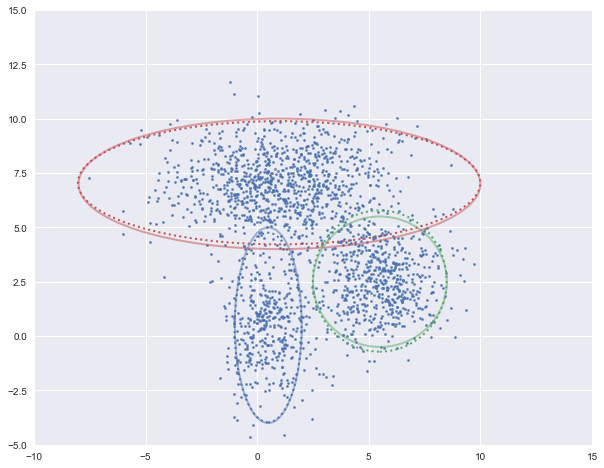

log-likehood:-4.714


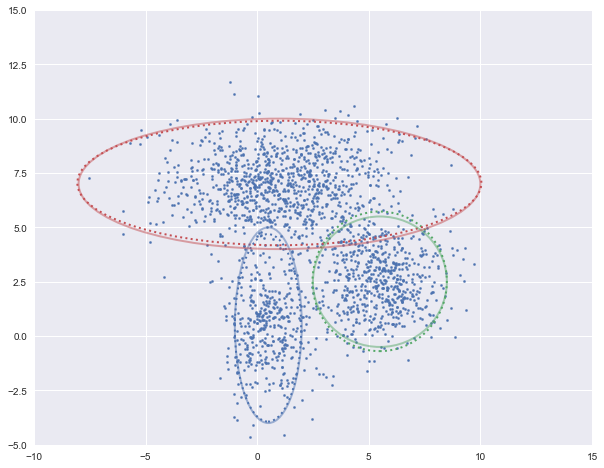

log-likehood:-4.714


In [130]:
loglh = []
for i in range(5):
    
    plot_clusters(X, Mu, Var, [mu1, mu2, mu3], [var1, var2, var3])
    
    loglh.append(logLH(X, Pi, Mu, Var))
    print('log-likehood:%.3f'%loglh[-1])
        
    # Expectation
    W = update_W(X, Mu, Var, Pi)
    Pi = update_Pi(W)
    
    # Maximization
    Mu = update_Mu(X, W)
    Var = update_Var(X, Mu, W)